# 02_Where are the people_Where is the work?

<div class="alert alert-block alert-info"><b>Exploratory analysis to understand the distribution of Economic Activity and the location of labour
</b> 
</div>


> **We assume economic activity = employment opportunity; then calculate and visualize *accessibility* as 15 minutes to employment in contrast to labour *walking* and *cycling* for 15 minutes from their residence.**
    
> `We'll move through these quickly. Although the MesoZone data is comprehensive with indicies for specific economic sectors we focus on cumulative.`

<div class="alert alert-block alert-warning"><b>Data:</b>
</div>

> **[CSIR](http://stepsa.org/socio_econ.html#Overview); MesoZones ~ *a functional demarcation to which a range of key socio-economic data [Economic activity / Population] sets get aligned on an intermediate level (meso-level) for spatial analysis.***

In [1]:
#load the magic

%matplotlib inline

import os
from pathlib import Path

import pandana as pdna

import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
path = Path('./')

In [4]:
meso_object = (path/'data'/'Mesozones.shp')
meso_shp = gpd.read_file(meso_object)
meso_shp = meso_shp.to_crs(4326)

# City Cape Town subcouncils for context
cpt_object = 'https://citymaps.capetown.gov.za/agsext1/rest/services/Theme_Based/Open_Data_Service/MapServer/77/query?where=1%3D1&outFields=SUB_CNCL_NAME,OBJECTID,SUB_CNCL_NMBR&outSR=4326&f=json'
metro_shp = gpd.read_file(cpt_object)
metro_shp = metro_shp.set_crs(epsg=4326)

# ... because the meso_zones cover the entire country we select only what we want
meso_sub = meso_shp[meso_shp['MunName16'] == 'City of Cape Town'].copy()

In [5]:
meso_sub.columns.values

array(['OBJECTID', 'MESO_ID', 'ProvCode16', 'MunCode16', 'MunName16',
       'DistCode16', 'DistName16', 'NSDF_URB_N', 'SA_FTT_Cat',
       'SA_FTT_Typ', 'FuncTownAr', 'POP_1996', 'POP_2001', 'POP_2011',
       'POP_2016', 'SIC1_1996', 'SIC2_1996', 'SIC3_1996', 'SIC4_1996',
       'SIC6_1996', 'SIC7_1996', 'SIC8_1996', 'SIC9_1996', 'SIC1_2001',
       'SIC2_2001', 'SIC3_2001', 'SIC4_2001', 'SIC6_2001', 'SIC7_2001',
       'SIC8_2001', 'SIC9_2001', 'SIC1_2011', 'SIC2_2011', 'SIC3_2011',
       'SIC4_2011', 'SIC6_2011', 'SIC7_2011', 'SIC8_2011', 'SIC9_2011',
       'SIC1_2016', 'SIC2_2016', 'SIC3_2016', 'SIC4_2016', 'SIC6_2016',
       'SIC7_2016', 'SIC8_2016', 'SIC9_2016', 'IsMetroLM', 'Shape_Leng',
       'Shape_Area', 'Shape_Le_1', 'Shape_Ar_1', 'geometry'], dtype=object)

<div class="alert alert-block alert-success">

<b> Noteworthy column definitions:
    
</b>  
     
    POP: Population;  
    SIC1: Agriculture, forestry and fishing;  
    SIC2: Mining and quarrying;  
    SIC3: Manufacturing;  
    SIC4: Electricity, gas and water;  
    SIC6: Wholesale and retail trade, catering and accommodation;  
    SIC7: Transport, storage and communication;  
    SIC8: Finance, insurance, real estate and business services; and   
    SIC9: General government,Community, social and personal services.
</div>

**We take what we want and `.copy()` to avoid a `SettingWithCopyWarning`. And create a new column with an `EconomicActivity_Total` for each *meso zone*.**

In [6]:
meso_sub_2016 = meso_sub[['OBJECTID', 'POP_2016', 'SIC1_2016', 'SIC2_2016', 'SIC3_2016',
                         'SIC4_2016', 'SIC6_2016', 'SIC7_2016', 'SIC8_2016', 'SIC9_2016', 'geometry']].copy()                  

In [7]:
#Total sum: 
meso_sub_2016['EconomicActivity_Total'] = (meso_sub_2016['SIC1_2016'] + meso_sub_2016['SIC2_2016'] + 
                                     meso_sub_2016['SIC3_2016'] + meso_sub_2016['SIC4_2016'] + 
                                     meso_sub_2016['SIC6_2016'] + meso_sub_2016['SIC7_2016'] + 
                                     meso_sub_2016['SIC8_2016'] + meso_sub_2016['SIC9_2016'])

<div class="alert alert-block alert-success"><b>
        
</b> **`pandana` only deals with `point` geometries, but the *MesoZones* are polygons so we create new `x` and `y` columns through the `geopandas.centroid` property: to represent a Zone as a `point`.**</div>

In [8]:
meso_sub_2016['x'] = meso_sub_2016['geometry'].centroid.x
meso_sub_2016['y'] = meso_sub_2016['geometry'].centroid.y

#meso_sub_2016.head(5)

C:\Users\EstelleSK\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
C:\Users\EstelleSK\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


<div class="alert alert-block alert-info"><b>

</b> **Load the saved OSM streets, extract the `nodes` and `edges` and build the `network`**</div>

In [9]:
%%time
#define path
osm_network = 'data/osm2Way_network_CPT_walk.h5'

store = pd.HDFStore(osm_network, "r")
store

Wall time: 6.04 s


<class 'pandas.io.pytables.HDFStore'>
File path: data/osm2Way_network_CPT_walk.h5

In [10]:
nodes = store.nodes
edges = store.edges

In [11]:
edges.head(2)
#nodes.head(2)

from          to   distance
18401303 6996959884  18401303  6996959884  13.726407
         6996986085  18401303  6996986085  13.499005

In [12]:
%%time
net = pdna.Network(nodes["x"], 
                   nodes["y"], 
                   edges["from"], 
                   edges["to"],
                   edges[["distance"]],
                   twoway=True)

Wall time: 13.4 s


<div class="alert alert-block alert-info"><b>Create accessibility variables</b> </div>

*~ extract the MesoZone centroids* and set the variables on the Pandana network   
*~ tie the centroids and values **[EconomicActivity and Population]** to the osm network.*

In [13]:
meso_sub_2016['node_id'] = net.get_node_ids(meso_sub_2016['x'], meso_sub_2016['y'])

In [14]:
net.set(meso_sub_2016.node_id, variable = meso_sub_2016.EconomicActivity_Total, name='employ')
net.set(meso_sub_2016.node_id, variable = meso_sub_2016.POP_2016, name='labour')

In [ ]:
# I experience challenges with this cell

#%%time
#net.precompute(5000)

<div class="alert alert-block alert-warning"><b>We calculate accessibility at 15 minutes</b>  
</div>

    
>- **Average walking speed is roughly 3mph or 5km/h [(Wikipedia, 2020)](https://en.wikipedia.org/wiki/Walking):** 
          ~ which is: 3 divide 4 [we want 15 minutes] *  1,609 [miles to km] = 1.206 km
    
>- **Typically a bike travels at 12mph or 19km/h [(Wikipedia, 2020)](https://en.wikipedia.org/wiki/Bicycle_performance):**
          ~ which is 12 divide 4 [we want 15 minutes] *  1,609 [miles to km] = 4.827 km
    
***How much employment is accessible 1.2 and 5 km from business centers and what can labour reach when traveling for 1.2 and 5 km from home?*** 

<div class="alert alert-block alert-danger"><b>Warning:
</b></div>

**NOTE:** We set `decay = 'linear'` and assume EconomicActivity and Population decreases from the center of the MesoZone. This is not necessarily so. `decay = 'flat'` would be more acurate but the visualization less dynamic.

**Calculate cumulative accessibility**
    
For each `pandana` network `node`, calculate the cumulative number of total economic activity and labour within a 1.2 and 5  km network radius.

In [15]:
%%time
employment_1 = net.aggregate(1200,
                         type = 'sum', 
                         decay = 'linear',       #can be set to 'flat'
                         name = 'employ')

employment_5 = net.aggregate(5000,
                         type = 'sum', 
                         decay = 'linear',      #can be set to 'flat'
                         name = 'employ')

Wall time: 1min 44s


In [16]:
%%time
labour_1 = net.aggregate(1200, 
                         type='sum', 
                         decay='linear',       #can be set to 'flat'
                         name = 'labour')

labour_5 = net.aggregate(5000, 
                         type='sum', 
                         decay='linear',       #can be set to 'flat'
                         name = 'labour')

Wall time: 1min 42s


<div class="alert alert-block alert-warning"><b>
    
</b>
    
    the new variables are (osm) network node id and ...in the case below cumulative economic activity
</div>

In [17]:
## example
employment_5.tail()

id
8274520656    17791.504793
8274520657    18427.166964
8274520658    17171.214783
8274520664    19157.519686
8274520668    19381.407308
dtype: float64

<div class="alert alert-block alert-info"><b>Plot</b></div>

<div class="alert alert-block alert-success"><b>Bounding box:</b></div>

>A very handy site (http://boundingbox.klokantech.com/) will give bbox coordinates in the format `(minx, maxx, miny, maxy)` which will allow you to zoom to an area of interest within `matplotlib`. Choose `csv`. ~ *be weary of the aspect ratio.*

In [18]:
zoomCPT_central = (18.401243,-34.099869,18.700964,-33.798554)
zoomCPT_east = (18.380289,-33.962738,18.683672,-33.861814)            #cpt ~ east
zoomCpt = (18.398937,-33.95546,18.50056,-33.882526)                   #cpt
zoomCpt_south = (18.44903,-34.10489,18.65159,-33.944977)              #cpt ~ closer
zoomCpt_tblview = (18.400213,-33.949344,18.551962,-33.799409)
zoomCpt_south = (18.401243,-34.099869,18.650495,-33.89892)

<div class="alert alert-block alert-warning"><b>City of Cape Town ~ Central: Employment / Labour ~ 15 Minutes Cycling</b> </div>

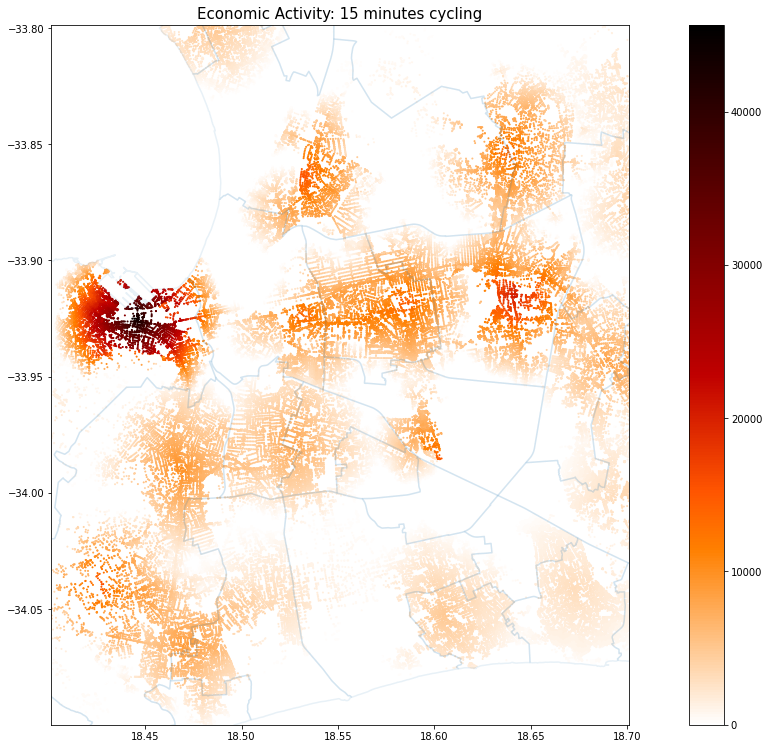

In [19]:
fig, ax = plt.subplots(figsize=(11,11))

ax.axis([zoomCPT_central[0], zoomCPT_central[2], zoomCPT_central[1], zoomCPT_central[3]])
cb = ax.scatter(net.nodes_df.x, net.nodes_df.y, 
            c=employment_5, s=1, cmap='gist_heat_r')
metro_shp.boundary.plot(ax=ax, alpha =0.1, zorder=1)
ax.set_title('Economic Activity: 15 minutes cycling', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
fig.colorbar(cb, cax=cax)

plt.tight_layout()
plt.show()

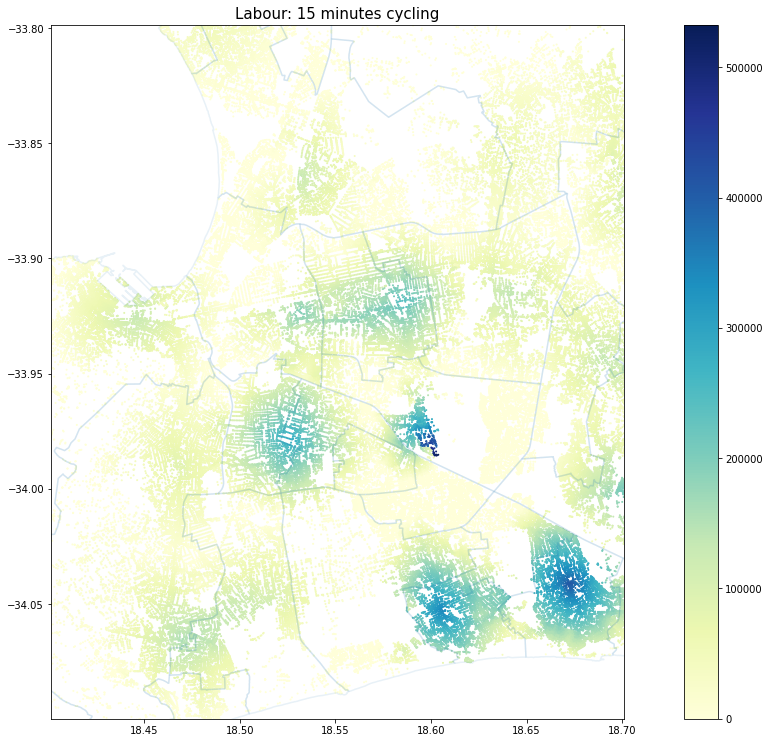

In [20]:
fig, ax = plt.subplots(figsize=(11,11))

ax.axis([zoomCPT_central[0], zoomCPT_central[2], zoomCPT_central[1], zoomCPT_central[3]])
cb = ax.scatter(net.nodes_df.x, net.nodes_df.y, 
            c=labour_5, s=1, cmap='YlGnBu')
metro_shp.boundary.plot(ax=ax, alpha =0.1, zorder=1)
ax.set_title('Labour: 15 minutes cycling', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
fig.colorbar(cb, cax=cax)

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning"><b>City of Cape Town ~ East: Employment / Labour ~ 15 Minutes Cycling</b> </div>

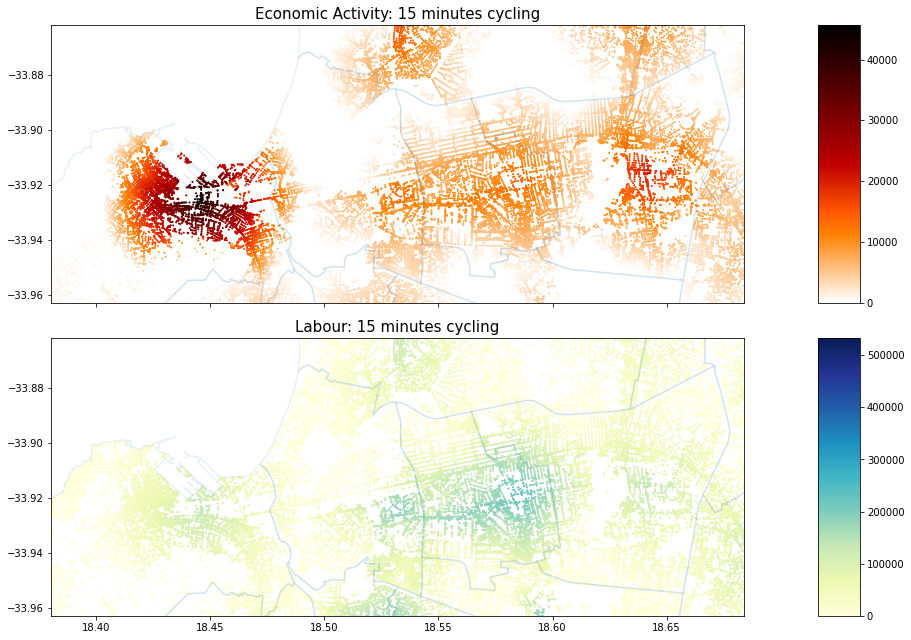

In [21]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(13,9), sharex='col')#, sharey='row')

ax1.set_aspect('equal')
ax1.axis([zoomCPT_east[0], zoomCPT_east[2], zoomCPT_east[1], zoomCPT_east[3]])
cb = ax1.scatter(net.nodes_df.x, net.nodes_df.y, 
            c=employment_5, s=1, cmap='gist_heat_r')
metro_shp.boundary.plot(ax=ax1, alpha = 0.1, zorder=1)
ax1.set_title('Economic Activity: 15 minutes cycling', fontsize=15)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cb, cax = cax1, ax=ax1)

ax2.set_aspect('equal')
ax2.axis([zoomCPT_east[0], zoomCPT_east[2], zoomCPT_east[1], zoomCPT_east[3]])
bc = ax2.scatter(net.nodes_df.x, net.nodes_df.y, 
            c=labour_5, s=1, cmap='YlGnBu')
metro_shp.boundary.plot(ax=ax2, alpha = 0.1, zorder=1)
ax2.set_title('Labour: 15 minutes cycling', fontsize=15)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(bc, cax = cax2, ax=ax2)

#fig.subplots_adjust(top=0.91)
#plt.subplots_adjust(wspace = 0.1, hspace = -0.55)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning"><b>City of Cape Town ~ South: Employment / Labour ~ 15 Minutes Cycling </b> </div>

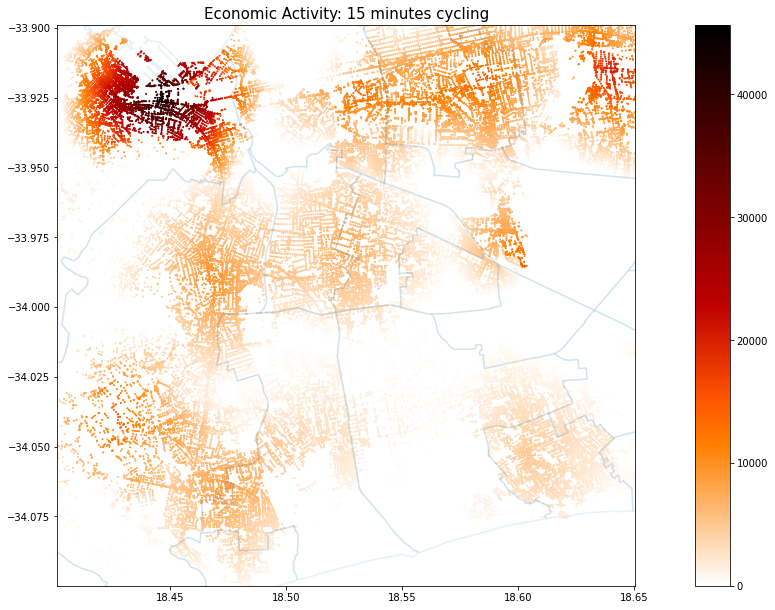

In [22]:
fig, ax = plt.subplots(figsize=(11,11))

ax.axis([zoomCpt_south[0], zoomCpt_south[2], zoomCpt_south[1], zoomCpt_south[3]])
cb = ax.scatter(net.nodes_df.x, net.nodes_df.y, 
            c=employment_5, s=1, cmap='gist_heat_r')
metro_shp.boundary.plot(ax=ax, alpha =0.1, zorder=1)
ax.set_title('Economic Activity: 15 minutes cycling', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
fig.colorbar(cb, cax=cax)

plt.tight_layout()
plt.show()

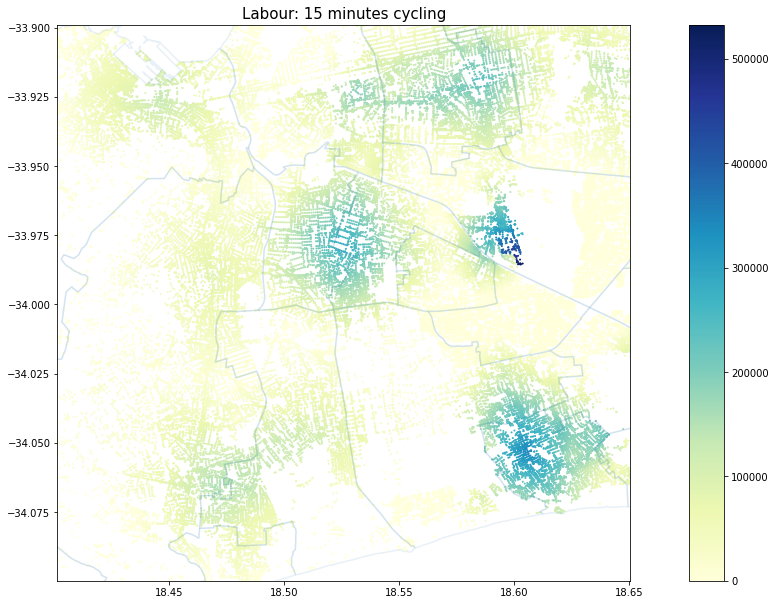

In [23]:
fig, ax = plt.subplots(figsize=(11,11))

ax.axis([zoomCpt_south[0], zoomCpt_south[2], zoomCpt_south[1], zoomCpt_south[3]])
cb = ax.scatter(net.nodes_df.x, net.nodes_df.y, 
            c=labour_5, s=1, cmap='YlGnBu')
metro_shp.boundary.plot(ax=ax, alpha =0.1, zorder=1)
ax.set_title('Labour: 15 minutes cycling', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
fig.colorbar(cb, cax=cax)

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning"><b>City of Cape Town ~ Tableview: Employment / Labour ~ 15 Minutes Cycling</b> </div>

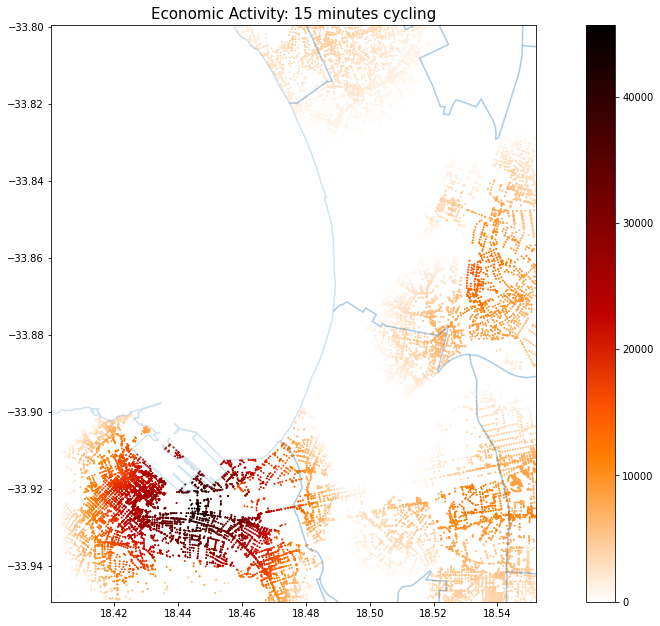

In [24]:
fig, ax = plt.subplots(figsize=(11, 11))
                        
plt.axis([zoomCpt_tblview[0], zoomCpt_tblview[2], zoomCpt_tblview[1], zoomCpt_tblview[3]])

cb = ax.scatter(net.nodes_df.x, 
                net.nodes_df.y, 
                c=employment_5, s=1, 
                cmap='gist_heat_r')
                       
metro_shp.boundary.plot(ax=ax, alpha = 0.2, zorder=1)
                       
ax.set_title('Economic Activity: 15 minutes cycling', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
fig.colorbar(cb, cax=cax)

plt.show()

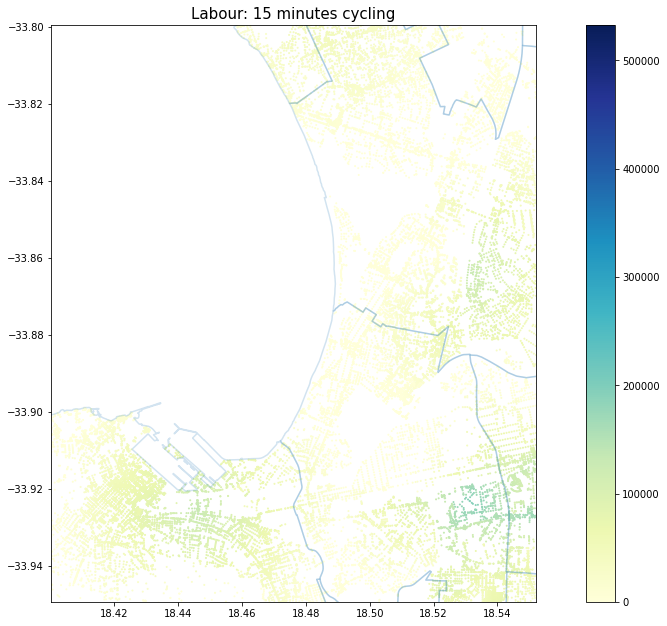

In [25]:
fig, ax = plt.subplots(figsize=(11, 11))
                        
plt.axis([zoomCpt_tblview[0], zoomCpt_tblview[2], zoomCpt_tblview[1], zoomCpt_tblview[3]])

cb = ax.scatter(net.nodes_df.x, 
                net.nodes_df.y, 
                c=labour_5, s=1, 
                cmap='YlGnBu')
                       
metro_shp.boundary.plot(ax=ax, alpha = 0.2, zorder=1)
                       
ax.set_title('Labour: 15 minutes cycling', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
fig.colorbar(cb, cax=cax)

plt.show()

<div class="alert alert-block alert-info"><b>Build a `GeoDataframe` with the data you want
</b></div>

> What do you want? ~ `nodes`, with values that describe location and accessibility to labour and employment.

In [39]:
employment_1.name = "employment_1"
employment_5.name = 'employment_5'
labour_1.name = 'labour_1'
labour_5.name = 'labour_5'

In [41]:
employment_1 = pd.DataFrame(employment_1)
employment_5 = pd.DataFrame(employment_5)
labour_1 = pd.DataFrame(labour_1)
labour_5 = pd.DataFrame(labour_5)

In [70]:
access = employment_1.join([employment_5, labour_1, labour_5])

data = access.merge(nodes, left_on='id', right_index=True, how = "left")

data.head(2)

,employment_1,employment_5,labour_1,labour_5,x,y
id,,,,,,
18401303,0.0,4209.445235,0.0,57961.020354,18.858736,-33.932268
18402016,0.0,4223.273227,0.0,58151.421817,18.878714,-33.929936


<div class="alert alert-block alert-success"><b>
    
    
</b>**Convert to `Dataframe` or `GeoDataFrame` and possible save as `csv` or `shapefile`.**</div>

In [72]:
data = pd.DataFrame(data)
#data.to_csv('access_employment_labour.csv')

## ---- or ---- ###

geometry = [Point(xy) for xy in zip(data.x, data.y)]
data = data.drop(['x', 'y'], axis=1)
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326", geometry=geometry)

#gdf.to_file('access_employment_labour.shp')